# Objective

Train a convolutional neural network (CNN) to recognize handwritten digits from the MNIST dataset. The training process will involve image augmentations to improve the robustness of the model, and model performance will be evaluated.

PyTorch will be used

Code adapted from: https://www.datacamp.com/tutorial/pytorch-cnn-tutorial

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm

In [2]:
!pip install torchvision
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import v2 as T
from torchvision.transforms import InterpolationMode

In [3]:
!pip install torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 66.2 MB/s eta 0:00:00


In [4]:
!pip install torchsummary

from torchsummary import summary

# Load MNIST Dataset

In [5]:
batch_size = 60

train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


Show random sample

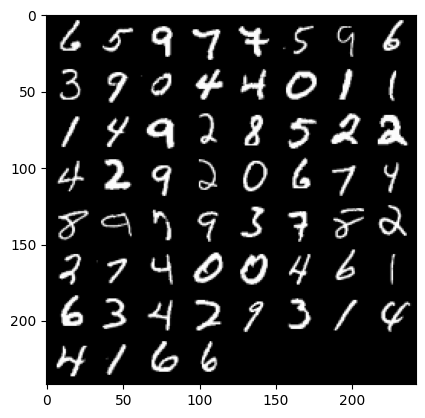

In [6]:
def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
# show images
imshow(torchvision.utils.make_grid(images))


# Data Augmentation

In [7]:
# Train: affine (rotate/translate/scale/shear) + one-of {elastic, perspective, pad+crop}
train_transform = T.Compose([
    T.RandomAffine(
        degrees=12,
        translate=(0.08, 0.08),
        scale=(0.88, 1.12),
        shear=[-10, 10, -10, 10],
        interpolation=InterpolationMode.BILINEAR,
        fill=0,
    ),
    T.RandomChoice([
        T.ElasticTransform(alpha=12.0, sigma=4.0),  # water-like local warps
        T.RandomPerspective(
            distortion_scale=0.08, p=1.0,
            interpolation=InterpolationMode.BILINEAR, fill=0
        ),
        T.Compose([T.Pad(1, fill=0), T.RandomCrop((28, 28))]),
    ]),
    T.ToTensor(),  # -> float32 in [0,1], shape [1,28,28] for MNIST (L)
])

# Eval/Test: no augmentations
test_transform = T.Compose([T.ToTensor()])


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Define loaders with augmentations (only for training)

In [8]:
batch_size = 60
train_dataset = datasets.MNIST(root="dataset/", train=True,  download=True, transform=train_transform)
test_dataset  = datasets.MNIST(root="dataset/", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define CNN Model

In [9]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        """
        Convolutional neural network for MNIST digits.

        Parameters:
            * in_channels: Number of channels in the input image (for MNIST, 1).
            * num_classes: Number of classes to predict (for digits 0–9, 10).
        """
        super(CNN, self).__init__()

        # --- Conv Block 1 ---
        self.conv1a = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1a   = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1  = nn.Dropout(0.25)

        # --- Conv Block 2 ---
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a   = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2  = nn.Dropout(0.25)

        # --- Classifier block ---
        self.fc1    = nn.Linear(64 * 7 * 7, 128)  # after 2 poolings: 28->14->7
        self.drop3  = nn.Dropout(0.5)
        self.fc2    = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        Forward pass of the CNN.

        Parameters:
            x: Input tensor of shape [batch_size, in_channels, 28, 28].

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, num_classes].
        """
        # Conv Block 1
        x = F.relu(self.conv1a(x))
        x = self.bn1a(x)
        x = F.relu(self.conv1b(x))
        x = self.pool1(x)
        x = self.drop1(x)

        # Conv Block 2
        x = F.relu(self.conv2a(x))
        x = self.bn2a(x)
        x = F.relu(self.conv2b(x))
        x = self.pool2(x)
        x = self.drop2(x)

        # Classifier
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)

        return x


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(in_channels=1, num_classes=10).to(device)
print(model)

CNN(
  (conv1a): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
model = CNN(in_channels=1, num_classes=10).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 32, 28, 28]           9,248
         MaxPool2d-4           [-1, 32, 14, 14]               0
           Dropout-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
       BatchNorm2d-7           [-1, 64, 14, 14]             128
            Conv2d-8           [-1, 64, 14, 14]          36,928
         MaxPool2d-9             [-1, 64, 7, 7]               0
          Dropout-10             [-1, 64, 7, 7]               0
           Linear-11                  [-1, 128]         401,536
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 468,010
Trainable params:

# Train + Validate

In [12]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
def evaluate(model, loader, criterion, device):
    """Compute average loss and accuracy over a DataLoader (no grad)."""
    model.eval()
    loss_sum, correct, n = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            n += x.size(0)
    return loss_sum / n, correct / n

In [14]:
# --- Train + Validate (with history) ----------------------------------------
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, running_correct, seen = 0.0, 0, 0

    for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        data, targets = data.to(device), targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss/acc online
        bs = data.size(0)
        running_loss += loss.item() * bs
        running_correct += (scores.argmax(1) == targets).sum().item()
        seen += bs

    train_loss = running_loss / seen
    train_acc  = running_correct / seen

    # Validation
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_acc)
    history["val_accuracy"].append(val_acc)

    print(f"Epoch {epoch+1:02d} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}")


Epoch 1/10: 100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]


Epoch 01 | train_loss=0.3689 acc=0.8848 | val_loss=0.0375 acc=0.9877


Epoch 2/10: 100%|██████████| 1000/1000 [01:03<00:00, 15.67it/s]


Epoch 02 | train_loss=0.1611 acc=0.9547 | val_loss=0.0377 acc=0.9887


Epoch 3/10: 100%|██████████| 1000/1000 [01:02<00:00, 16.05it/s]


Epoch 03 | train_loss=0.1213 acc=0.9658 | val_loss=0.0237 acc=0.9915


Epoch 4/10: 100%|██████████| 1000/1000 [01:03<00:00, 15.68it/s]


Epoch 04 | train_loss=0.1056 acc=0.9706 | val_loss=0.0265 acc=0.9929


Epoch 5/10: 100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s]


Epoch 05 | train_loss=0.0954 acc=0.9722 | val_loss=0.0219 acc=0.9925


Epoch 6/10: 100%|██████████| 1000/1000 [01:02<00:00, 15.95it/s]


Epoch 06 | train_loss=0.0905 acc=0.9747 | val_loss=0.0192 acc=0.9944


Epoch 7/10: 100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


Epoch 07 | train_loss=0.0845 acc=0.9765 | val_loss=0.0214 acc=0.9938


Epoch 8/10: 100%|██████████| 1000/1000 [01:02<00:00, 16.06it/s]


Epoch 08 | train_loss=0.0785 acc=0.9781 | val_loss=0.0271 acc=0.9923


Epoch 9/10: 100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]


Epoch 09 | train_loss=0.0796 acc=0.9778 | val_loss=0.0198 acc=0.9948


Epoch 10/10: 100%|██████████| 1000/1000 [01:02<00:00, 15.98it/s]


Epoch 10 | train_loss=0.0731 acc=0.9794 | val_loss=0.0167 acc=0.9948


# Evaluate trained model

## Loss and accuracy curves

In [15]:
def plot_loss_and_accuracy(history, figsize=(8, 8), suptitle="Training & Validation Curves"):
    """
    history: dict with keys
      'loss', 'val_loss', 'accuracy', 'val_accuracy'  (each a list of floats per epoch)
    """
    required = ["loss", "val_loss", "accuracy", "val_accuracy"]
    missing = [k for k in required if k not in history]
    if missing:
        raise KeyError(f"Missing keys in history: {missing}")

    epochs = np.arange(1, len(history["loss"]) + 1)

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    fig.suptitle(suptitle, fontsize=14)

    axes[0].plot(epochs, history["loss"], label="train_loss")
    axes[0].plot(epochs, history["val_loss"], label="val_loss")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss curve")
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].legend(loc="best")

    axes[1].plot(epochs, history["accuracy"], label="train_acc")
    axes[1].plot(epochs, history["val_accuracy"], label="val_acc")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy curve")
    axes[1].grid(True, linestyle="--", alpha=0.4)
    axes[1].legend(loc="best")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

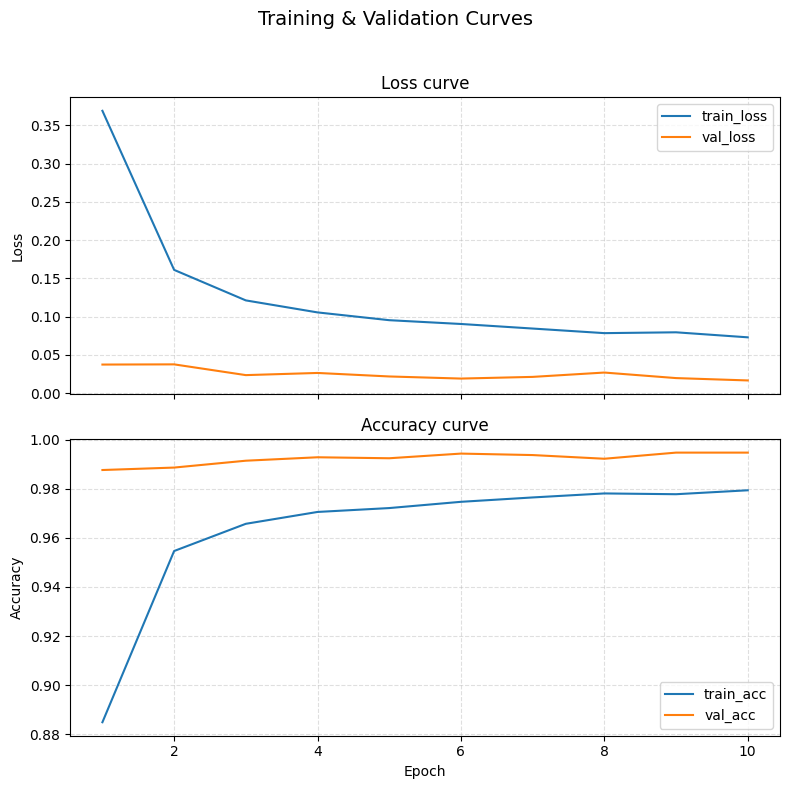

In [16]:
plot_loss_and_accuracy(history)

In [17]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.0167 | Test Acc: 0.9948


## Confusion Matrix

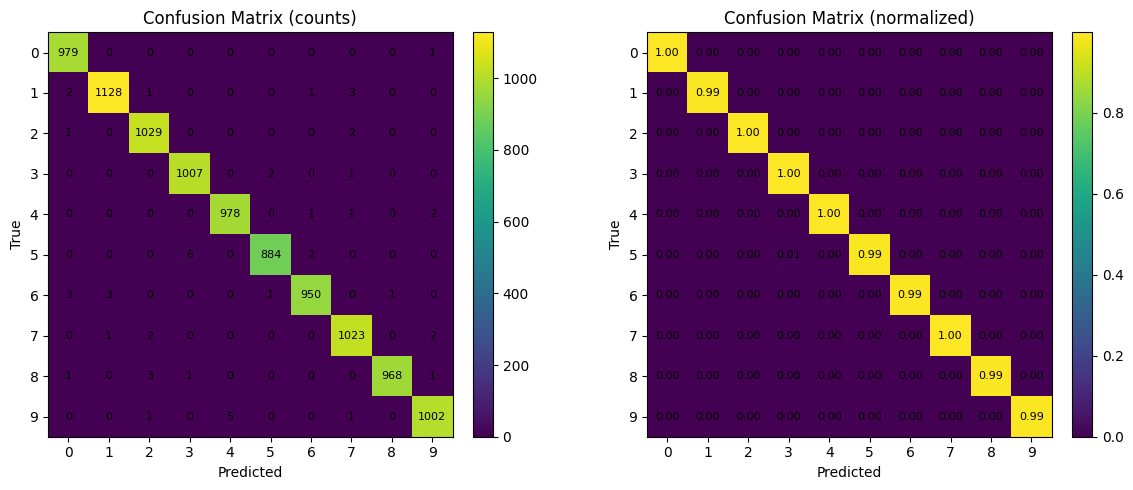


Classification report:
               precision    recall  f1-score   support

           0     0.9929    0.9990    0.9959       980
           1     0.9965    0.9938    0.9951      1135
           2     0.9932    0.9971    0.9952      1032
           3     0.9931    0.9970    0.9951      1010
           4     0.9949    0.9959    0.9954       982
           5     0.9966    0.9910    0.9938       892
           6     0.9958    0.9916    0.9937       958
           7     0.9922    0.9951    0.9937      1028
           8     0.9990    0.9938    0.9964       974
           9     0.9940    0.9931    0.9936      1009

    accuracy                         0.9948     10000
   macro avg     0.9948    0.9948    0.9948     10000
weighted avg     0.9948    0.9948    0.9948     10000



In [18]:
from sklearn.metrics import confusion_matrix, classification_report

# --- Predictions on test ----------------------------------------------------
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

# --- Confusion matrices -----------------------------------------------------
cm = confusion_matrix(y_true, y_pred, labels=range(10))
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("True")
ax[0].set_xticks(range(10)); ax[0].set_yticks(range(10))
for i in range(10):
    for j in range(10):
        ax[0].text(j, i, int(cm[i, j]), ha='center', va='center', fontsize=8)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# Normalized
im1 = ax[1].imshow(cm_norm, interpolation='nearest')
ax[1].set_title("Confusion Matrix (normalized)")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("True")
ax[1].set_xticks(range(10)); ax[1].set_yticks(range(10))
for i in range(10):
    for j in range(10):
        ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center', fontsize=8)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout(); plt.show()

# --- Classification report -------------------------------------------------
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))


# Save and Reload Model

In [19]:
MODEL_PATH = "mnist_cnn.pth"

# --- Save model -------------------------------------------------------------
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved at: {MODEL_PATH}")

# --- Reload model -----------------------------------------------------------
# Debes recrear la clase CNN con la misma arquitectura
reloaded = CNN(in_channels=1, num_classes=10).to(device)
reloaded.load_state_dict(torch.load(MODEL_PATH, map_location=device))
reloaded.eval()
print("Reloaded model summary:")
print(reloaded)   # en PyTorch imprime la arquitectura

# --- Sanity check prediction after reload ----------------------------------
reloaded.eval()
with torch.no_grad():
    sample_x, _ = test_dataset[0]         # un tensor (1,28,28)
    sample_x = sample_x.unsqueeze(0).to(device)  # batch=1, shape (1,1,28,28)
    probs = torch.softmax(reloaded(sample_x), dim=1).cpu().numpy()[0]

print("Example probs (test[0]):", np.round(probs, 3), " | argmax:", int(np.argmax(probs)))


Model saved at: mnist_cnn.pth
Reloaded model summary:
CNN(
  (conv1a): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1a): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Example probs (test[0]): [0

# Test the model

idx=1234 | y_true=8 | y_pred=8


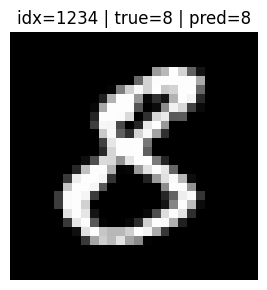

In [20]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_probs(test_index, model, dataset, device="cpu"):
    model.eval()
    with torch.no_grad():
        img, true_label = dataset[test_index]   # img: [1,28,28], true_label: int
        img_in = img.unsqueeze(0).to(device)    # add batch dim -> [1,1,28,28]

        logits = model(img_in)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    pred_label = int(np.argmax(probs))
    print(f"idx={test_index} | y_true={true_label} | y_pred={pred_label}")

    # show image
    plt.figure(figsize=(3,3))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"idx={test_index} | true={true_label} | pred={pred_label}")
    plt.axis("off"); plt.tight_layout(); plt.show()

    # horizontal bar chart
    digits = [str(i) for i in range(10)]
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=probs, y=digits, orientation="h",
        hovertemplate='Digit %{y}: %{x:.4f}<extra></extra>'
    ))
    fig.update_layout(
        title=f"Class probabilities (idx={test_index}, pred={pred_label})",
        xaxis_title="Probability", yaxis_title="Digit",
        yaxis=dict(categoryorder="array", categoryarray=digits),
        margin=dict(l=80, r=40, t=60, b=40), bargap=0.15
    )
    fig.show()

# Example usage
test_index = 1234
plot_probs(test_index, reloaded, test_dataset, device)
